# 1. MNIST Dataset Exploration with FiftyOne

Welcome to the first notebook in our series on image classification with FiftyOne. In this series we will explore foundational ideas on image classification, image embeddings, and model comparison.

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/mnist_clean.webp?raw=1)

In this first step, we will load the classic [MNIST dataset](https://docs.voxel51.com/dataset_zoo/datasets.html#dataset-zoo-mnist) from the [FiftyOne Dataset Zoo](https://docs.voxel51.com/dataset_zoo/datasets.html), explore its structure, and compute and visualize its metadata. This initial exploration is important for understanding the data we'll be working with in the next steps. It will also help you gain familiarity with the FiftyOne app and SDK. 

**Key concepts covered:**
*   Loading datasets from the FiftyOne Dataset Zoo
*   Computing image metadata (size, width, height)
*   Using FiftyOne aggregations for data statistics
*   Visualizing dataset distributions in the FiftyOne App

## Installation

First, let's install the required packages. These are the Python packages that we will use for the whole series of notebooks. The [requirements.txt]() file has the exact set of versions that I have used to make the environment run. 

Remember to create a virtual environment with 

```bash
python -m venv .venv 
```
and to activate it with

```bash
source .venv/bin/activate
```
This environment must be selected as the interpreter for this notebook.

These notebooks werre tested on a Runpod.io PyTorch 2.1 environment with 1X RTX 2000 Ada and 6 vCPU with 31 GB RAM. 


In [1]:
# Remove > /dev/null if you encounter errors after installation, we have it just to keep the notebook clean.
!pip install -r requirements.txt > /dev/null

## Imports

In [2]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from torch.utils.data import Dataset, ConcatDataset
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import albumentations as A
import cv2
import random
from typing import Optional, Dict, Tuple, Any

### Loading the MNIST Dataset from FiftyOne's Dataset Zoo

A FiftyOne dataset wraps together annotations and image data into a unified, queryable structure. Unlike traditional approaches where you manage separate files for images and labels, FiftyOne treats each sample as a rich object containing the image, ground truth labels, metadata, and any predictions or embeddings you add later.

Loading MNIST from the [FiftyOne Dataset Zoo](https://docs.voxel51.com/dataset_zoo/index.html) is straightforward. We'll start by loading the test split.

In [3]:
# We will load the test split from the dataset first. 
# We set persistent=True on the dataset to keep our changes through different Python sessions.
test_dataset = foz.load_zoo_dataset("mnist", split='test', dataset_name="mnist-test-set", persistent=True)
test_dataset

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.99MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 220kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.13MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.96MB/s]

   3% |/------------|   295/10000 [101.3ms elapsed, 3.3s remaining, 2.9K samples/s] 

 100% |█████████████| 10000/10000 [3.3s elapsed, 0s remaining, 3.0K samples/s]      
Dataset info written to '/root/fiftyone/mnist/info.json'
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [5.1s elapsed, 0s remaining, 2.1K samples/s]      
Dataset 'mnist-test-set' created


Name:        mnist-test-set
Media type:  image
Num samples: 10000
Persistent:  True
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)

Let's launch the FiftyOne App to visualize the test set.

In [4]:
session = fo.launch_app(test_dataset, auto=False)
print(session.url)

Session launched. Run `session.show()` to open the App in a cell output.

Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|

http://0.0.0.0:5151/


![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/MNIST-vis.webp?raw=true)

With `compute_metadata()`, we can easily add metadata like image size, width, height, and number of channels to each sample in our dataset.

In [5]:
test_dataset.compute_metadata()
# Refresh the session to ensure the dataset view in the app is updated
session.refresh()

Computing metadata...
 100% |█████████████| 10000/10000 [6.1s elapsed, 0s remaining, 1.9K samples/s]      


This metadata is wrapped together with our samples and we can inspect it through the FiftyOne app. We can click on the `JSON` icon `{}` to retrieve it when we need it. 

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/mnist_five.webp?raw=1)

The only field in the samples of the dataset that is mandatory is the local `filepath`. All other annotations and tags are optional for the FiftyOne dataset. The `id` field is a hash that is automatically generated for each sample and allows us to identify each data point uniquely (even if we had duplicate images in the dataset). The dataset for MNIST that we have downloaded from the FiftyOne dataset zoo has come prepared in this format. 
FiftyOne is a "logical database" that connects our media files (images, video, geolocation data, etc.) with all its annotations and metadata. MongoDB is the default database backend. 

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/five_json.webp?raw=1)

From the `JSON` window, we can copy any field, here I take the filepath to open the image within my notebook. 

In [10]:
image = Image.open("/root/fiftyone/mnist/test/data/000016.jpg")
image

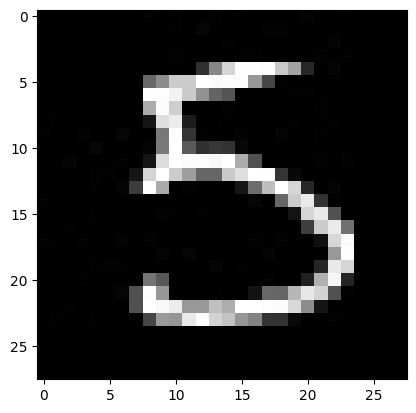

In [ ]:
# Each image is 28x28 pixels and represented in grayscale, FiftyOne upsamples the images for easy inspection within the app.
im_array = np.array(image)
plt.imshow(im_array, cmap='gray');

We can perform [aggregations](https://docs.voxel51.com/user_guide/using_aggregations.html) on the dataset to explore the metadata. For example, we can find the range, mean, and standard deviation of the image sizes in bytes.

In [6]:
print(f'File size (bytes) range: {test_dataset.bounds("metadata.size_bytes")}')
print(f'File size (bytes) mean: {test_dataset.mean("metadata.size_bytes"):.2f}')
print(f'File size (bytes) std dev: {test_dataset.std("metadata.size_bytes"):.2f}')

File size (bytes) range: (483, 1033)
File size (bytes) mean: 768.61
File size (bytes) std dev: 84.01


### Visualizing the Ground Truth Label Distribution

In the FiftyOne App, you can visualize the distributions of any field. This is useful for checking class balance or understanding metadata distributions.

1. Click the `+` symbol next to the `Samples` tab.
2. Select `Histograms`.
3. Choose `ground_truth.label` from the dropdown to see the class distribution.
4. Press `Split horizontally` to see the MNST images alongside their class distribution.

You should see that the classes are overall balanced, which simplifies training and evaluation. There is only a slight dominance of 1s in the distribution. 

![](https://github.com/andandandand/practical-computer-vision/blob/main/images/ground_truh_distribution_mnist.png?raw=true)

In [7]:
session.refresh()
print(session.url)

## Exercise

* Repeat the histogram visualization process on `metadata.size_bytes` and select the field from the METADATA navigation bar. You should be able to produce a visualization with the `size_bytes` distribution like the one shown below. 

![](https://github.com/andandandand/fiftyone/blob/develop/docs/source/getting_started_experiences/Classification/assets/MNIST_size_byes.webp?raw=true)

## Next Steps

Now that we have explored the basic properties of the MNIST dataset, we are ready for the next step: creating image embeddings with CLIP to understand the semantic relationships between images.

Proceed to `step_2_clip_embeddings.ipynb`.